In [6]:
using PyPlot; plt=PyPlot
using PyCall
using FastGaussQuadrature, Compat
using LinearAlgebra
using JLD

In [7]:
# line cyclers adapted to colourblind people
cycler = pyimport("cycler").cycler
line_cycler   = (cycler(color=["#E69F00", "#56B4E9", "#009E73", "#0072B2", "#D55E00", "#CC79A7", "#F0E442","#E69F00", "#56B4E9", "#009E73", "#0072B2", "#D55E00", "#CC79A7", "#F0E442"]) +
                 cycler(linestyle=["-", "--", "-.", ":", "-", "--", "-.", ":","-", "--", "-.", ":", "-", "--"]))
marker_cycler = (cycler(color=["#E69F00", "#56B4E9", "#009E73", "#0072B2", "#D55E00", "#CC79A7", "#F0E442"]) +
                 cycler(linestyle=["none", "none", "none", "none", "none", "none", "none"]) +
                 cycler(marker=["4", "2", "3", "1", "+", "x", "."]))

# matplotlib's standard cycler
standard_cycler = cycler("color", ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"])

plt.rc("axes", prop_cycle=line_cycler)

In [8]:
include("mPDeC.jl")
include("mPRK.jl")

SIRK3 (generic function with 1 method)

In [9]:
problem="system2D"
folder="outputs/"
folder = string(folder,"system/")
mkpath(folder)

"outputs/system"

## Most generic 2x2 linear system
$$
\begin{cases}
u_1'= -\theta u_1 + (1-\theta) u_2\\
u_2'= +\theta u_1 - (1-\theta) u_2
\end{cases}
$$

This should represent all the linear production destruction problems with 2 costituents. A variation in the coefficients can be rescaled with time.

A general initial condition is
$$
\begin{pmatrix}
u_1^0\\u_2^0
\end{pmatrix}
=\begin{pmatrix}
1-\varepsilon\\\varepsilon
\end{pmatrix}
$$

any other IC can be given by a rescaling factor on the whole solution.

The steady state solution of this problem is $$
\begin{pmatrix}
u_1^*\\u_2^*
\end{pmatrix}
=\begin{pmatrix}
1-\theta\\\theta
\end{pmatrix}.
$$

### Oscillations
The exact solution of the system is monotone in time in both variables. 
Let us consider a numerical scheme of the type $u^{n+1}=g(u^{n})$. We observe oscillations in this approximation if the new value overshoot the steady state, i.e.,
$$
(u_1^{n+1}-u_1^*)*(u_1^{n}-u_1^*)<0.
$$
In particular, we might want a scheme not to oscillate for any initial condition and system ($\theta$), hence, we can find bounds for $\Delta t$, such that for $\Delta t \leq \Delta_0$ we do not observe any oscillation.

To find the oscillatory scheme, we define an overshoot measure given by
$$
m(u_1^{n+1},u_1^n,u_1^*) : = \begin{cases}
\max\left( (u^{n+1}_1-u^n_1)^+,(u^*_1-u^{n+1}_1)^+\right) & \text{if }u^n_1>u^*_1\\
\max\left( (u^n_1-u^{n+1}_1)^+,(u^{n+1}_1-u^*_1)^+\right) & \text{if }u^n_1\leq u^*_1
\end{cases}
%\left( \left\lvert u_1^{n+1} -  u_1^n\right\rvert -\left\lvert u_1^{n} -  u_1^*\right\rvert \right)^+
$$
that returns zero if we do not overshoot the steady state, and it returns the measure of the overshoot if there is overshoot.

In [12]:
function positive_part(x)
    return max(x,0)
end
function negative_part(x)
    return -min(x,0)
end

function overshootMeasure(u0,u1,ustar)
    """
    This function gives a measure of how much we overshoot the steady state, if we do not overshoot it, returns 0.
    A small tolerance of 5*machine epsilons is added to allow machine precision errors.
    """
    tol=5*eps()
    if u0>ustar
        return max(positive_part(u1-u0-tol),positive_part(ustar-u1-tol))
    else
        return max(positive_part(u0-u1-tol),positive_part(u1-ustar-tol))
    end
end

overshootMeasure (generic function with 1 method)

In [11]:
function rhs_function(u)
    """
    Extra term in the PDS when also a non PD term is present.
    """
    return zeros(length(u))
end


rhs_function (generic function with 1 method)

## Computing the nonoscillatory $\Delta t$ bound for  different schemes
This implies checking for each scheme (which might depend on parameters) for any possible system ($\theta$) and any possible initial condition ($\varepsilon$), for which $\Delta t$ the scheme gives 0 oscillations. 

### MPRK22($\alpha$) method
Its description can be found in [Burchard et al. APNUM 47 (2003)](https://doi.org/10.1016/S0168-9274(03)00101-6)

In [13]:
# System parameters 
epsilons = [1e-100; 10.0 .^ (-7.8:0.3:-1); 0.1:0.02:0.49999999999] #10.0 .^ (-8:0.1:-0.3)
extraθs=1.0 .-10.0 .^(-1:-0.3:-10)
θs = [10.0 .^(-10:0.3:-1);(0.1:0.02:0.9); extraθs]

# Scheme parameters
dts=(0.5:0.025:20)#2.0 .^ (-2.0:0.01:4.0)
αs = range(0.5,stop=10,length=96)

0.5:0.1:10.0

The next cell computes the solution for many schemes, it requires a lot of time. If julia is allowed to use more cores, it will perform the loop in a multi-thread fashion.

In [23]:
# If this cell has been already computed in the past, it can be skipped, all data are saved

l1=length(αs)
l2= length(θs)

AA=zeros(l1,l2)
BB=zeros(l1,l2)
QQ=zeros(l1,l2)

#Loop on schemes α
Threads.@threads for i1=1:l1
    α=αs[i1]
    print(i1)
    tmp=1.0
    
    #Loop on problems θ
    for i2=1:l2
        θ=θs[i2]
        AA[i1,i2]=α
        BB[i1,i2]=θ
        
        # Production and destruction functions of the problem
        param_a,param_b=  (1-θ),θ
        function prod_dest(c)
            d= length(c)
            p=zeros(d,d)
            d=zeros(d,d)
            p[1,2]=param_a*c[2]
            d[2,1]=param_a*c[2]
            p[2,1]=param_b*c[1]
            d[1,2]=param_b*c[1]
            return p, d
        end

        # Steady state
        uInf=[param_a param_b]
        
        
        
        z=0
        overshoots=zeros(size(dts))
        us=zeros(size(dts))
        
        # Loop on the timesteps
        for dt in dts
            z+=1
            tt=0:dt:dt
            overEps=zeros(size(epsilons))
            r=0
            
            # Loop on all the initial conditions
            for ep=epsilons
                r+=1
                u0=[1-ep ep]
                
                # Check if we overshoot and saving the result in overEps 
                # (if troubles with the method occur, we save a 1)
                try
                    tout,uu=mPRK22(prod_dest, rhs_function, tt,u0, α)
                    tmp= overshootMeasure(uu[1,1],uu[1,2],uInf[1])
                    if isnan(tmp)
                        tmp=1.0
                    end
                catch e
                    tmp=1.0
                end
                overEps[r]=tmp
            end
            
            # Finding the maximum overshoot over different IC for a given Δt and θ 
            overshoots[z]=maximum(overEps)
        end
        
        # Finding the largest Δt0 for which there are no overshoots for Δt < Δt0
        if isempty(dts[overshoots.==0])
            QQ[i1,i2] = 0.
        else
            QQ[i1,i2] = maximum(dts[overshoots.==0]);
        end

        
    end
end

# Saving data to file
save(string(folder,"RK2CFLallEps.jld"), "AA", AA,"BB",BB,"QQ", QQ)

371731385496125267414388625062277539871536351287688416405264297758917415365307869042185466317991743195567328089220564468338193921574569348222941058467035839511235947713684961224486072

Plot the $\Delta t$ bound for all scheme parameters ($\alpha$) and problems ($\theta$)

sys:1: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


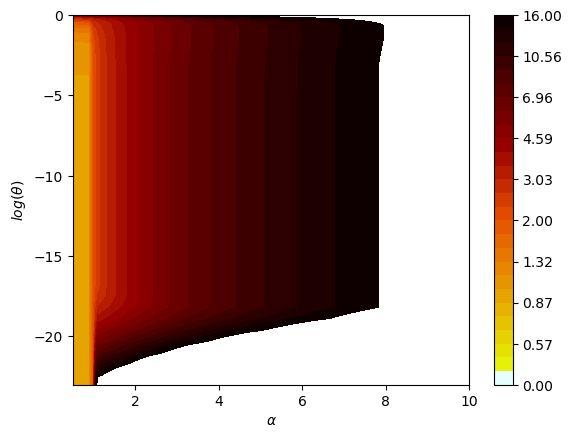

In [45]:
# Loading data
AA = load(string(folder,"RK2CFLallEps.jld"), "AA")
BB = load(string(folder,"RK2CFLallEps.jld"), "BB")
QQ = load(string(folder,"RK2CFLallEps.jld"), "QQ")

# Color levels
levels=[0 
    2^-6
    2. .^range(-1,stop=4,step=0.2)] #    range(0.1,stop=2.5,length=60)

nLevels=length(levels)
k=nLevels
colls=zeros(nLevels,3)
colls[:,1]=[min(-1.6*(x-1),0.9) for x in range(0,stop=1,length=nLevels)]
colls[:,2]=[max(-1.6*x+1,0) for x in range(0,stop=1,length=nLevels)]#1-sqrt.(2*x*(1-x))
colls[:,3]=[-1/(k^2-1).+k/(k^2-1)./((k-1/k).*x.+1/k) for x in range(0,stop=1,length=nLevels)]

# Contour plot
PyPlot.contourf(AA,log.(BB),QQ,levels, colors=colls)
PyPlot.colorbar()
PyPlot.xlabel(L"\alpha")
PyPlot.ylabel(L"$log(\theta)$")
#PyPlot.title("log10 Variation Lyapunov mPRK3")
PyPlot.savefig(string(folder,"RK2CFLallEps.pdf"))
PyPlot.show()


Comparing the solution with the theoretical upper bound of the $\Delta t$ bound

sys:1: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
sys:1: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


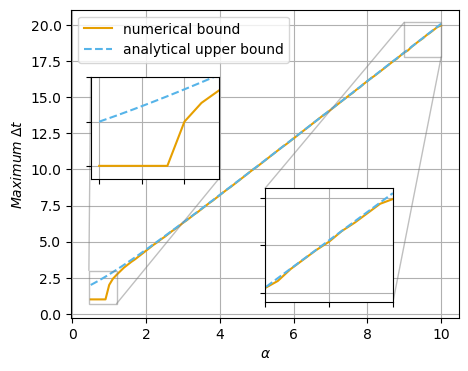

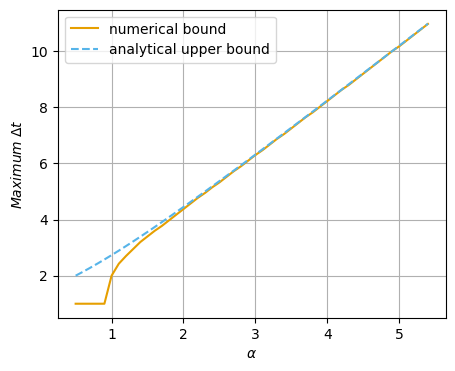

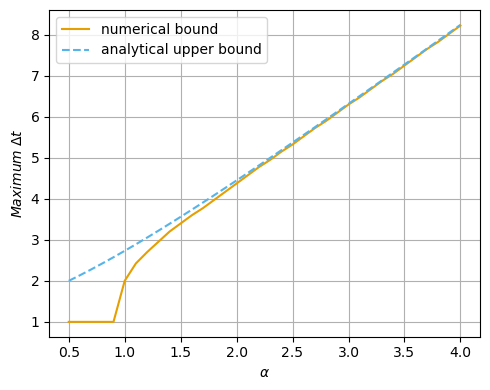

In [46]:
minα=[minimum(QQ[i,:]) for i in range(1,length=size(QQ,1))]
fig = plt.figure(figsize=(5,4))
ax= plt.axes()
plt.plot(αs,minα, label="numerical bound")
plt.plot(αs,αs .+ sqrt.(αs.^2 .+ 2) , label="analytical upper bound")
plt.xlabel(L"\alpha")
plt.ylabel(L"Maximum\; \Delta t")
plt.grid(true)

# inset axes....

axins = ax.inset_axes([0.05, 0.45, 0.33, 0.33])
axins.plot(αs,minα, label="numerical bound")
axins.plot(αs,αs .+ sqrt.(αs.^2 .+ 2) , label="analytical upper bound")
# sub region of the original image
x1, x2, y1, y2 = 0.45, 1.2, 0.7, 3.0
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.set_xticklabels([])
axins.set_yticklabels([])
axins.grid(true)

# inset axes....
axins2 = ax.inset_axes([0.5, 0.05, 0.33, 0.37])
axins2.plot(αs,minα, label="numerical bound")
axins2.plot(αs,αs .+ sqrt.(αs.^2 .+ 2) , label="analytical upper bound")
# sub region of the original image
x1, x2, y1, y2 = 9.0, 10.0, 17.8, 20.2
axins2.set_xlim(x1, x2)
axins2.set_ylim(y1, y2)
axins2.set_xticklabels([])
axins2.set_yticklabels([])
axins2.grid(true)



ax.indicate_inset_zoom(axins, edgecolor="gray")
ax.indicate_inset_zoom(axins2, edgecolor="gray")



plt.legend()

plt.savefig(string(folder,"RK2CFLallEpsAllSystems.pdf"))
plt.show()

plt.figure(figsize=(5,4))

minα=[minimum(QQ[i,:]) for i in range(1,length=size(QQ,1))]
plt.plot(αs[1:50],minα[1:50], label="numerical bound")
plt.plot(αs[1:50],αs[1:50] .+ sqrt.(αs[1:50].^2 .+ 2) , label="analytical upper bound")
plt.xlabel(L"\alpha")
plt.ylabel(L"Maximum\; \Delta t")
plt.legend(loc="best")
plt.grid(true)

plt.savefig(string(folder,"RK2CFLallEpsAllSystems_small.pdf"))

plt.show()

plt.figure(figsize=(5,4))

minα=[minimum(QQ[i,:]) for i in range(1,length=size(QQ,1))]
plt.plot(αs[1:36],minα[1:36], label="numerical bound")
plt.plot(αs[1:36],αs[1:36] .+ sqrt.(αs[1:36].^2 .+ 2) , label="analytical upper bound")
plt.xlabel(L"\alpha")
plt.ylabel(L"Maximum\; \Delta t")
plt.legend()
plt.grid(true)
plt.tight_layout()

plt.savefig(string(folder,"RK2CFLallEpsAllSystems_small2.pdf"))

### MPDeC equispaced all orders

Schemes of [Öffner and Torlo, APNUM 153 (2020)](https://doi.org/10.1016/j.apnum.2020.01.025)
Checking for MPDeC for all orders up to 16 and for equispaced and Gauss Lobatto points

equispacedOrder 1 Order 1 Maximum CFL 61.819925051190125
Order 2 Order 2 Maximum CFL 2.0
Order 3 Order 3 Maximum CFL 1.189207115002721
Order 4 Order 4 Maximum CFL 1.109569472067845
Order 5 Order 5 Maximum CFL 1.0717734625362931
Order 6 Order 6 Maximum CFL 1.0352649238413776
Order 7 Order 7 Maximum CFL 1.0352649238413776
Order 8 Order 8 Maximum CFL 1.3660402567543954
Order 9 Order 9 Maximum CFL 6.964404506368992
Order 10 Order 10 Maximum CFL 1.0
Order 11 Order 11 Maximum CFL 15.454981262797531
Order 12 Order 12 Maximum CFL 1.0
Order 13 Order 13 Maximum CFL 35.50622310617105
Order 14 Order 14 Maximum CFL 1.0717734625362931
Order 15 Order 15 Maximum CFL 12.125732532083186
Order 16 Order 16 Maximum CFL 1.8025009252216604
gaussLobattoOrder 1 Order 1 Maximum CFL 61.819925051190125
Order 2 Order 2 Maximum CFL 2.0
Order 3 Order 3 Maximum CFL 1.189207115002721
Order 4 Order 4 Maximum CFL 1.0717734625362931
Order 5 Order 5 Maximum CFL 1.0352649238413776
Order 6 Order 6 Maximum CFL 1.0
Order 7 Or

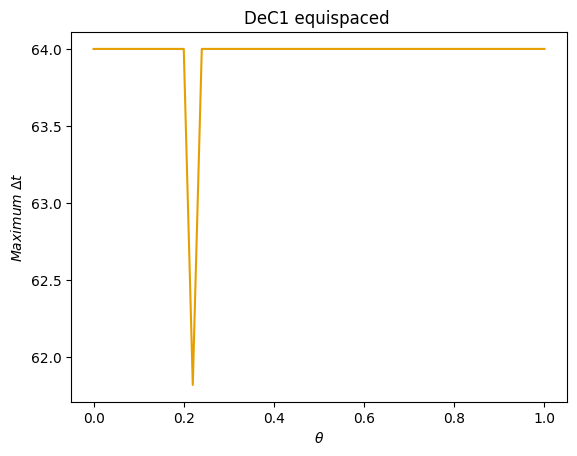

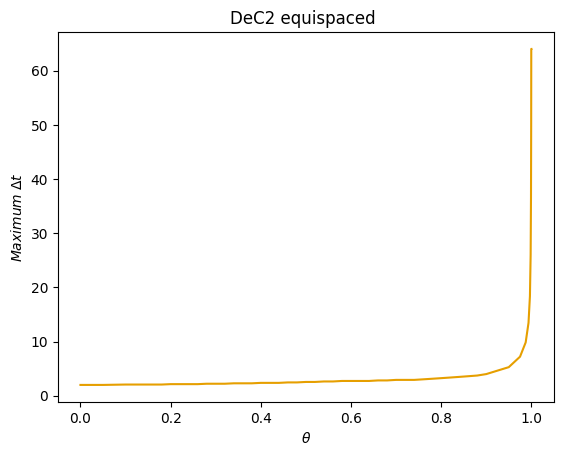

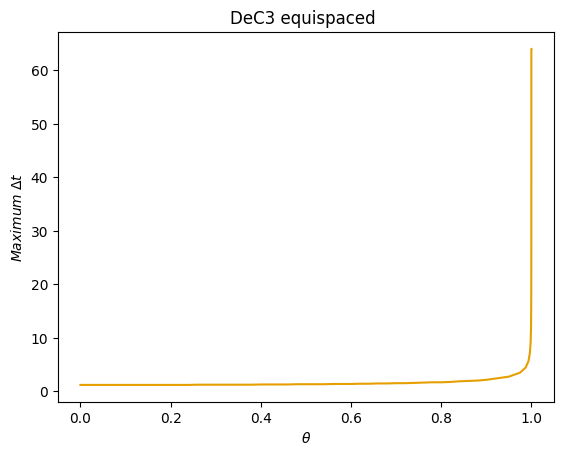

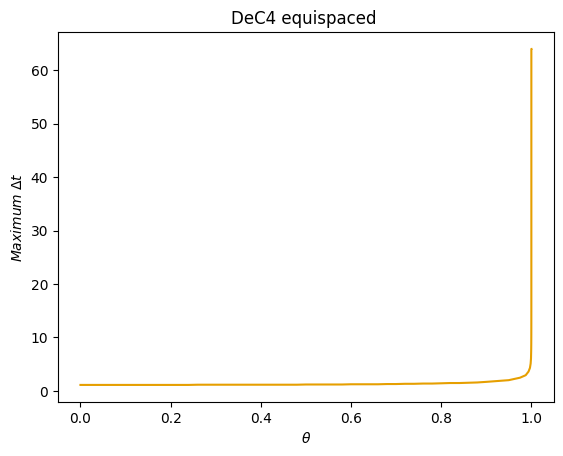

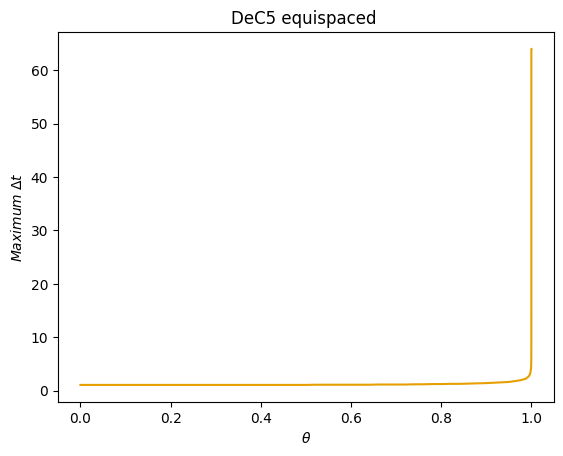

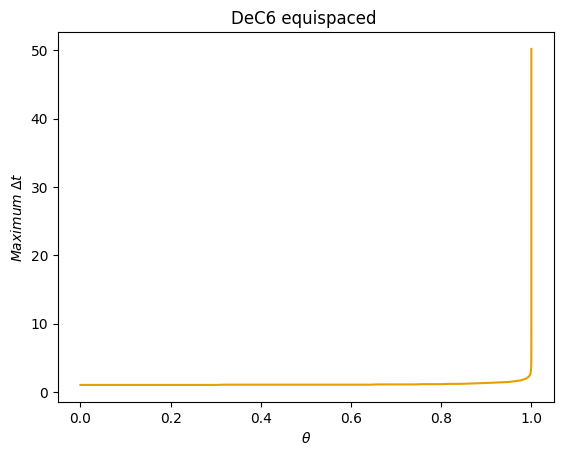

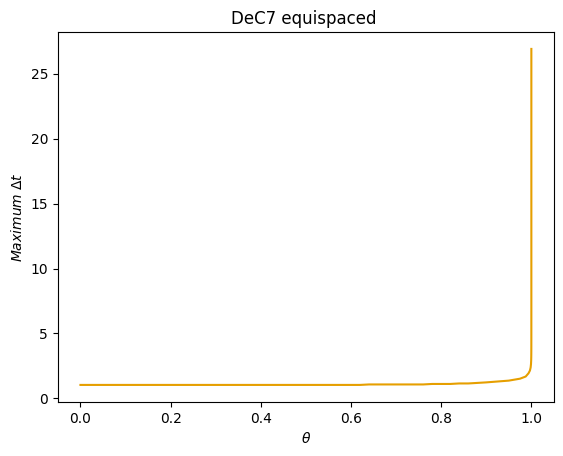

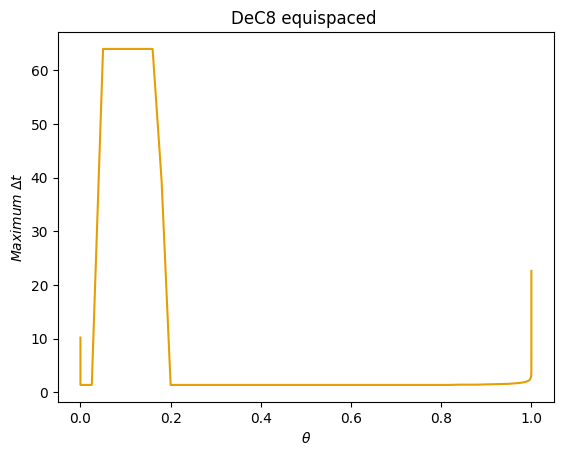

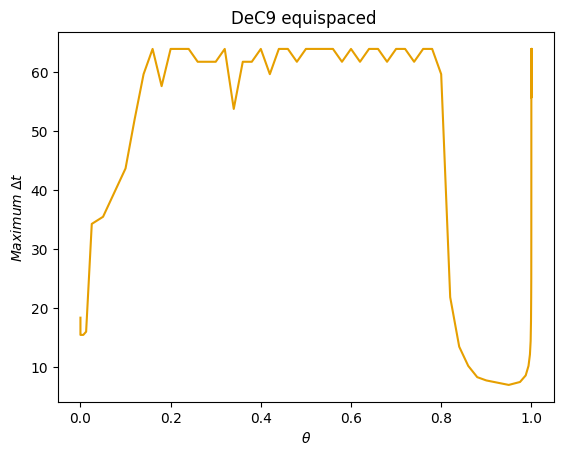

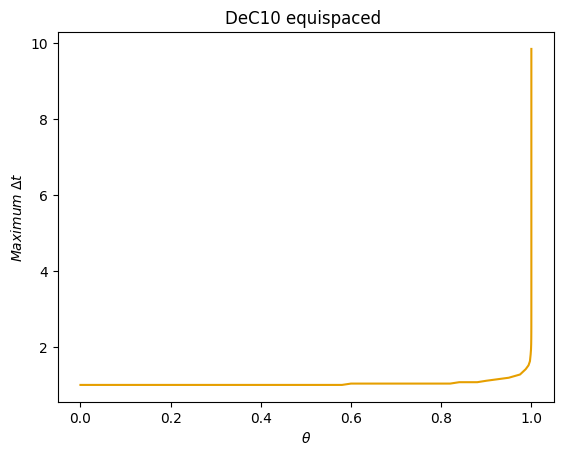

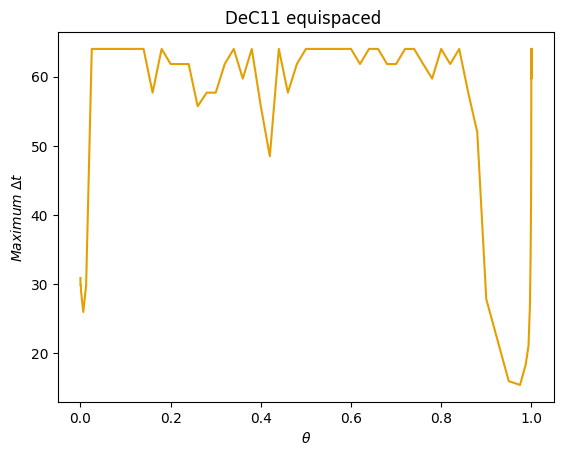

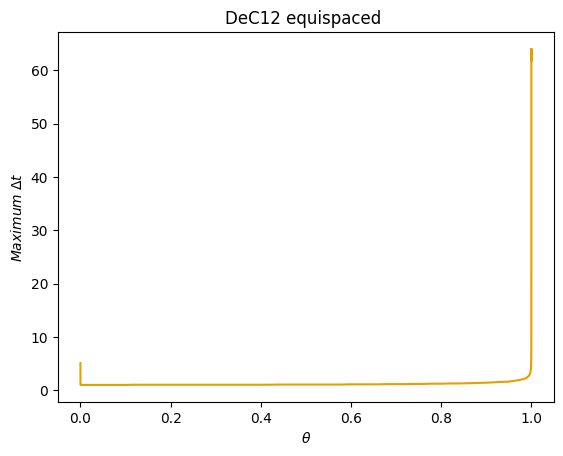

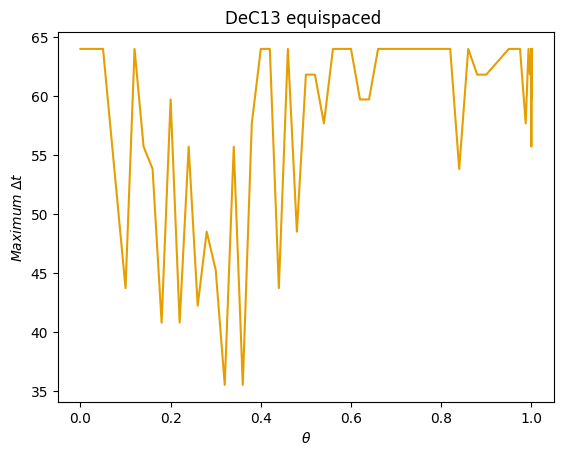

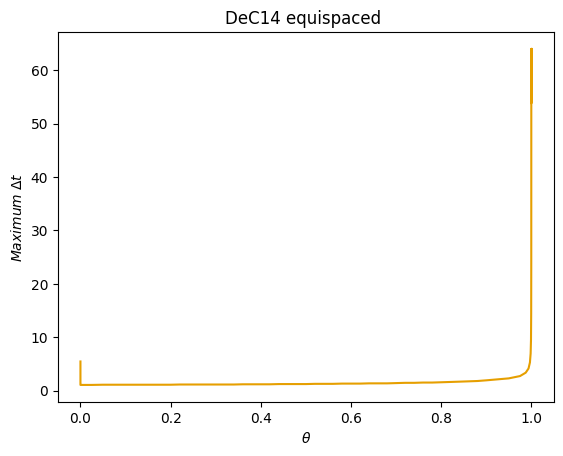

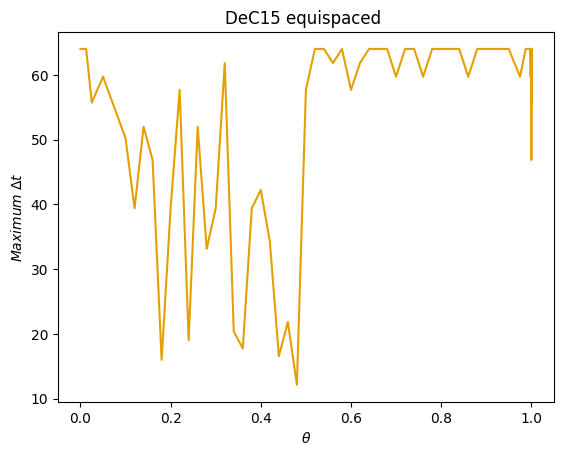

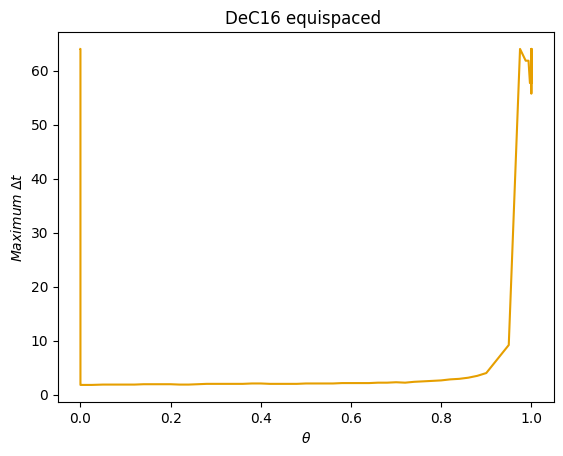

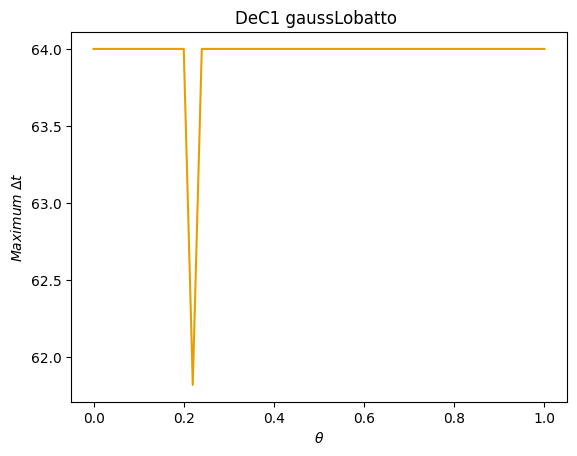

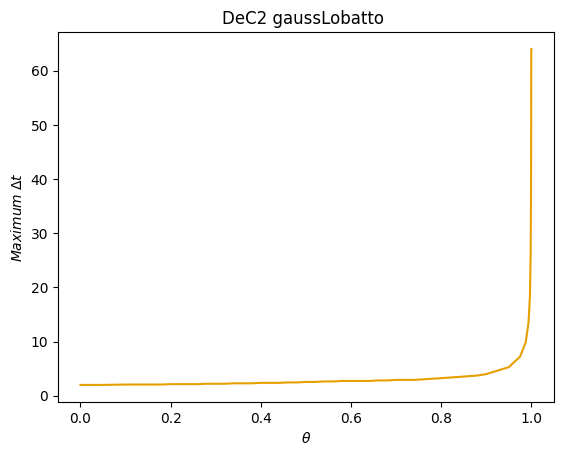

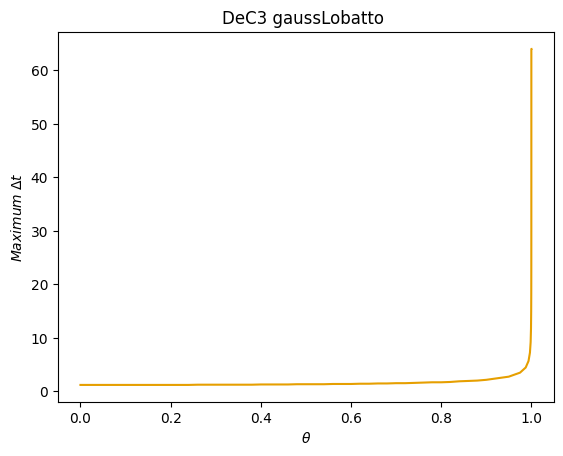

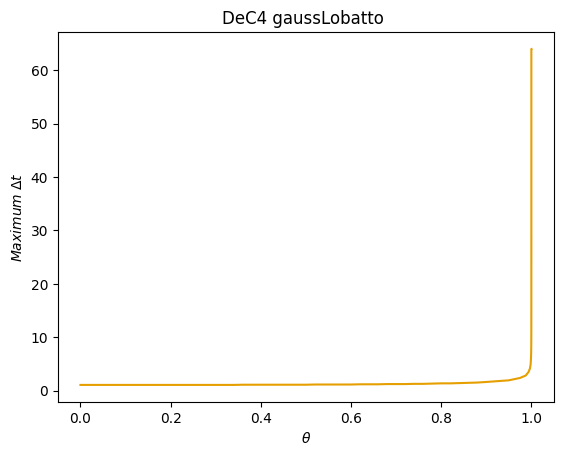

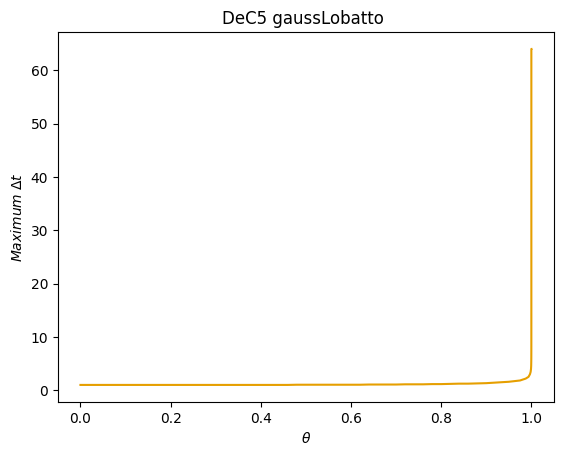

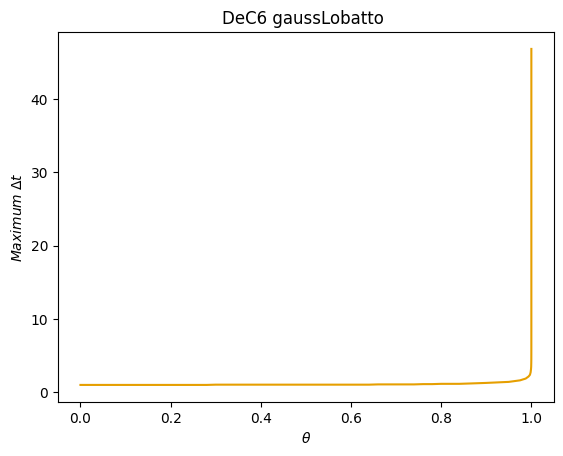

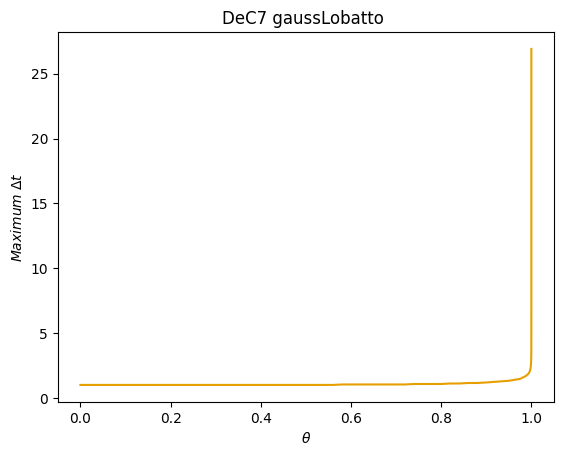

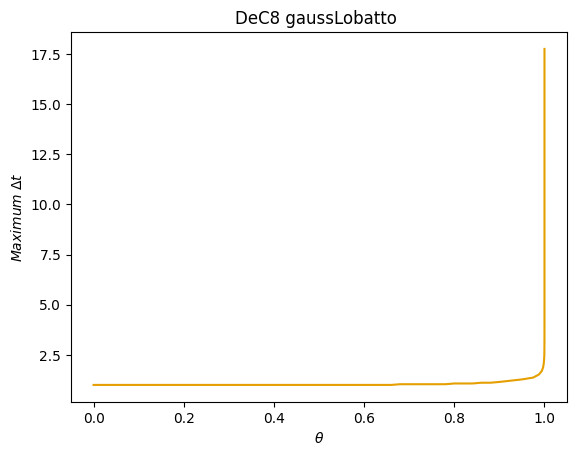

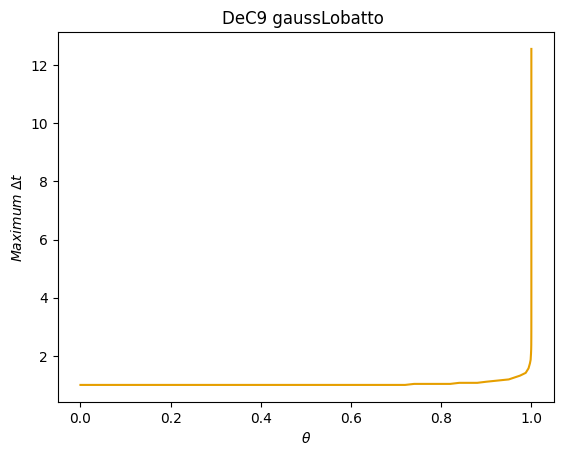

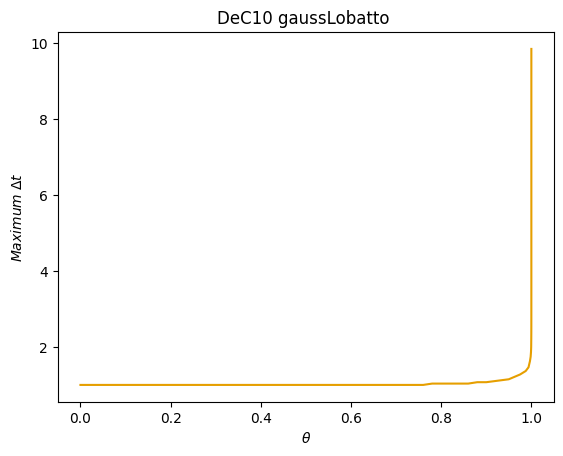

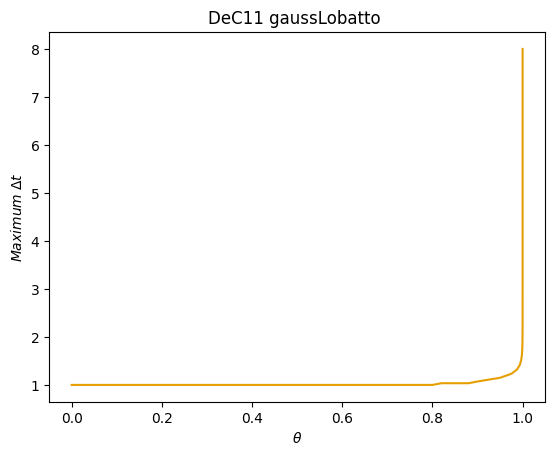

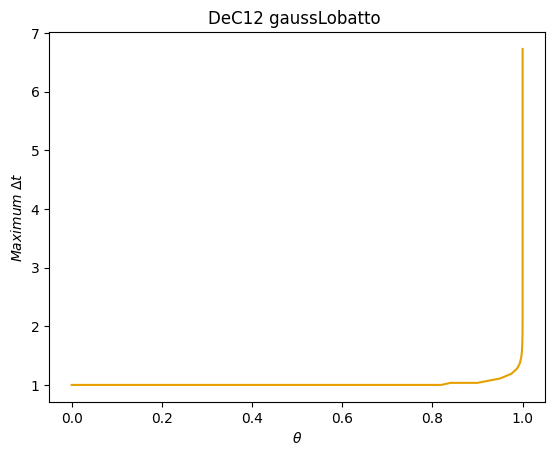

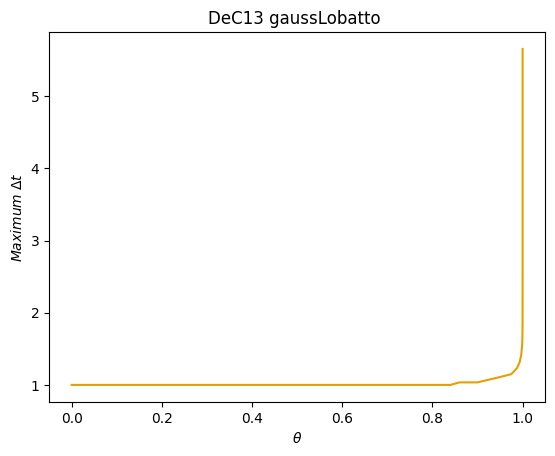

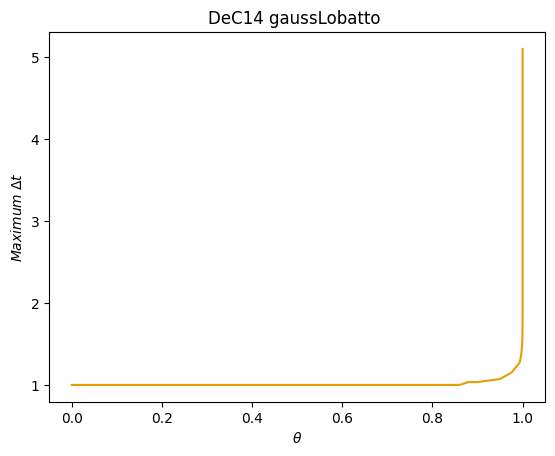

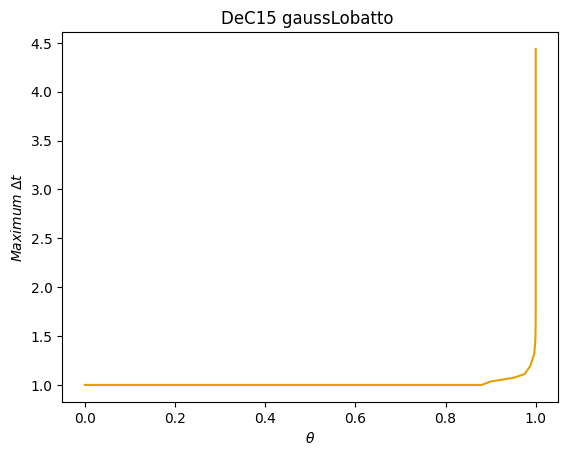

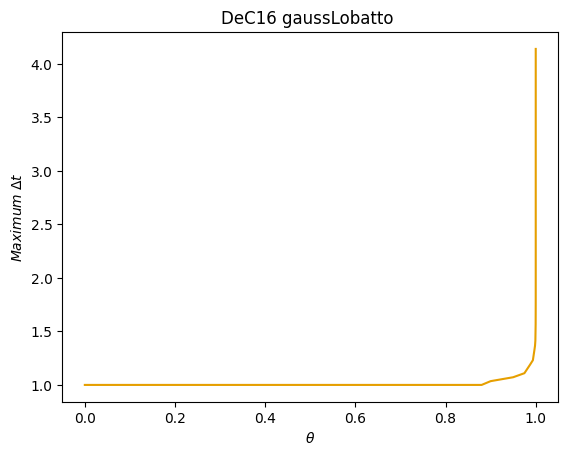

Order 16 Maximum CFL 1.0


In [11]:
# Problem setting
epsilons = [1e-100; 10.0 .^ (-7.8:0.3:-1); 0.1:0.02:0.49999999999] #10.0 .^ (-8:0.1:-0.3)
extraθs=1.0 .-10.0 .^(-1:-0.3:-10)
θs = [10.0 .^(-10:0.3:-1);(0.1:0.02:0.9); extraθs]

# Scheme setting
dts=2.0 .^ (-3.0:0.05:6.0)
distributions=["equispaced","gaussLobatto"]
distrShort=["eq","glb"]


l2= length(θs)

#Looping on time nodes distribution
for (idist, dist) in enumerate(distributions)
    print(dist)
    open(string(folder,"CFLDeC$(distrShort[idist])AllSystems.tex"), "w") do io
        write(io,"Order & Maximum \$\\Delta t\$ \\\\ \\hline \n")

        # Loop on orders of MPDeC
        for order=1:16
            print("Order $(order) ")
            QQ=zeros(l2)
            
            #Loop on problems θ
            Threads.@threads for i2=1:l2
                
                # Setting the production destruction function for the given problem
                θ = θs[i2]
                param_a,param_b=  (1-θ),θ #10^2, 10^2 # 1, 1 # 
                function prod_dest(c)
                    d= length(c)
                    p=zeros(d,d)
                    d=zeros(d,d)
                    p[1,2]=param_a*c[2]
                    d[2,1]=param_a*c[2]
                    p[2,1]=param_b*c[1]
                    d[1,2]=param_b*c[1]
                    return p, d
                end
                
                # Steady state of the problem
                uInf=[param_a param_b]

                z=0
                overshoots=zeros(size(dts))
                us=zeros(size(dts))
                tmp=1.0
                
                # Loop on the timesteps
                for dt in dts
                    z+=1
                    tt=0:dt:dt
                    overEps=zeros(size(epsilons))
                    r=0
                    
                    # Loop on all the initial conditions
                    for ep=epsilons
                        r+=1
                        u0=[1-ep ep]
                        
                        # Check if we overshoot and saving the result in overEps 
                        # (if troubles with the method occur, we save a 1)
                        try
                            tout,uu=dec_correction(prod_dest, rhs_function, tt,u0, max(order-1,1),order,dist)
                            tmp= overshootMeasure(uu[1,1],uu[1,2],uInf[1])
                            if isnan(tmp)
                                tmp=1.0
                            end
                        catch e
                            tmp=1.0
                        end
                        overEps[r]=tmp
                    end
            
                    # Finding the maximum overshoot over different IC for a given Δt and θ 
                    overshoots[z]=maximum(overEps)
                end
        
                # Finding the largest Δt0 for which there are no overshoots for Δt < Δt0
                if isempty(dts[overshoots.==0])
                    QQ[i2] = 0.
                else
                    QQ[i2] = maximum(dts[overshoots.==0]);
                end
            end
            
            # Plot of figure Δt bound vs θ and printing the result and saving it in a tex file
            plt.figure()
            plt.plot(θs, QQ)
            plt.xlabel(L"\theta")
            plt.ylabel(L"Maximum\; \Delta t ")
            plt.title("DeC$(order) $(dist) ")
            println("Order $(order) Maximum CFL $(minimum(QQ))")
            write(io, "   $(order) & $(minimum(QQ)) \\\\ \n")
        end
    end
end

### MPRKSO(4,3)
This correspond to the scheme proposed in [Huang et al. J Sci Comput 79, (2019)](https://doi.org/10.1007/s10915-018-0881-9) for $\eta_2=\frac{1}3$

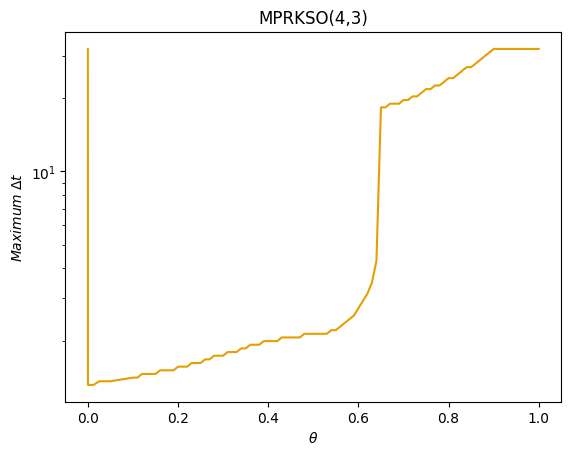

Maximum CFL 1.3195079107728942


In [15]:
# System paramters
epsilons = [1e-10; 10.0 .^ (-7.8:0.1:-1); 0.1:0.02:0.49999999999] #10.0 .^ (-8:0.1:-0.3)
extraθs=1.0 .-10.0 .^(-1:-0.3:-10)
θs = [10.0 .^(-10:0.3:-1);(0.1:0.01:0.9); extraθs]
l2= length(θs)

#Scheme parameters
dts=2.0 .^ (-4.0:0.05:5.0)



QQ=zeros(l2)

#Loop on problems θ
Threads.@threads for i2=1:l2
    θ = θs[i2]
        
    # Production and destruction functions of the problem
    param_a,param_b=  (1-θ),θ
    function prod_dest(c)
        d= length(c)
        p=zeros(d,d)
        d=zeros(d,d)
        p[1,2]=param_a*c[2]
        d[2,1]=param_a*c[2]
        p[2,1]=param_b*c[1]
        d[1,2]=param_b*c[1]
        return p, d
    end

    # Steady state
    uInf=[param_a param_b]



    z=0
    overshoots=zeros(size(dts))
    us=zeros(size(dts))
    tmp=1.0
    
    # Loop on the timesteps
    for dt in dts
        z+=1
        tt=0:dt:dt
        overEps=zeros(size(epsilons))
        r=0
        for ep=epsilons
            r+=1
            u0=[1-ep ep]
            
            # Check if we overshoot and saving the result in overEps 
            # (if troubles with the method occur, we save a 1)
            try
                tout,uu=mPRKSO3(prod_dest, rhs_function, tt,u0)
                tmp= overshootMeasure(uu[1,1],uu[1,2],uInf[1])
                if isnan(tmp)
                    tmp=1.0
                end
            catch e
                tmp=1.0
            end
            overEps[r]=tmp
        end
            
        # Finding the maximum overshoot over different IC for a given Δt and θ 
        overshoots[z]=maximum(overEps)
    end
        
    # Finding the largest Δt0 for which there are no overshoots for Δt < Δt0
    if isempty(dts[overshoots.==0])
        QQ[i2] = 0.
    else
        QQ[i2] = maximum(dts[overshoots.==0]);
    end
end

# Plot Δt bound with respect to θ
plt.figure()
plt.semilogy(θs, QQ)
plt.xlabel(L"\theta")
plt.ylabel(L"Maximum\; \Delta t ")
plt.title("MPRKSO(4,3)")

# Printing the Δt bound for all problems
println("Maximum CFL $(minimum(QQ))")

plt.savefig(string(folder,"RKSO43CFLallEpsVaryTheta.pdf"))

### MPRK(3,2) inspired from a SSPRK(3,3) 
The method description can be found in [Torlo et al. APNUM 182 (2022)](https://doi.org/10.1016/j.apnum.2022.07.014)

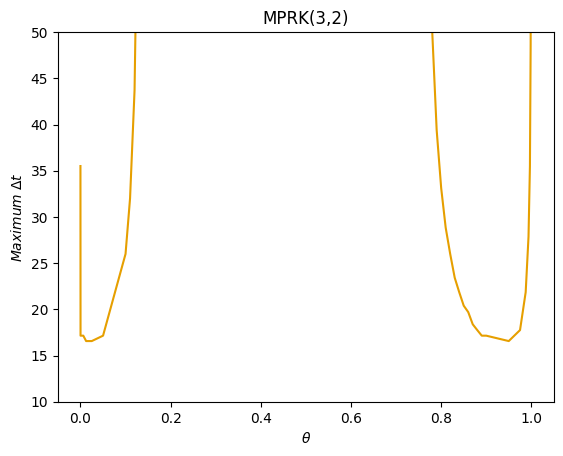

Maximum CFL 16.564238781462038


In [16]:
# System parameters 
epsilons = [1e-10; 10.0 .^ (-7.8:0.1:-1); 0.1:0.02:0.49999999999] #10.0 .^ (-8:0.1:-0.3)
extraθs=1.0 .-10.0 .^(-1:-0.3:-10)
θs = [10.0 .^(-10:0.3:-1);(0.1:0.01:0.9); extraθs]

l2= length(θs)


# Scheme parameters
dts=2.0 .^ (-2.0:0.05:8.0)



#Loop on problems θ
QQ=zeros(l2)
Threads.@threads for i2=1:l2
    θ = θs[i2]
    
    # Production and destruction functions of the problem
    param_a,param_b=  (1-θ),θ
    function prod_dest(c)
        d= length(c)
        p=zeros(d,d)
        d=zeros(d,d)
        p[1,2]=param_a*c[2]
        d[2,1]=param_a*c[2]
        p[2,1]=param_b*c[1]
        d[1,2]=param_b*c[1]
        return p, d
    end

    # Steady state
    uInf=[param_a param_b]


    z=0
    overshoots=zeros(size(dts))
    us=zeros(size(dts))
    tmp=1.0
    
    # Loop on the timesteps
    for dt in dts
        z+=1
        tt=0:dt:dt
        overEps=zeros(size(epsilons))
        r=0
        
        # Loop on all the initial conditions
        for ep=epsilons
            r+=1
            u0=[1-ep ep]
            
            # Check if we overshoot and saving the result in overEps 
            # (if troubles with the method occur, we save a 1)
            try
                tout,uu=mPRK32(prod_dest, rhs_function, tt,u0)
                tmp= overshootMeasure(uu[1,1],uu[1,2],uInf[1])
                if isnan(tmp)
                    tmp=1.0
                end
            catch e
                tmp=1.0
            end
            overEps[r]=tmp
        end
        
        # Finding the maximum overshoot over different IC for a given Δt and θ 
        overshoots[z]=maximum(overEps)
    end
    
    # Finding the largest Δt0 for which there are no overshoots for Δt < Δt0
    if isempty(dts[overshoots.==0])
        QQ[i2] = 0.
    else
        QQ[i2] = maximum(dts[overshoots.==0]);
    end
end

# Figure bound Δt wrt θ
plt.figure()
plt.plot(θs, QQ)
plt.ylim([10,50])
plt.xlabel(L"\theta")
plt.ylabel(L"Maximum\; \Delta t ")
plt.title("MPRK(3,2)")


# Printing bound for all problems
println("Maximum CFL $(minimum(QQ))")

plt.savefig(string(folder,"RK32CFLallEpsVaryTheta.pdf"))

### MPRKSO22($\alpha$,$\beta$)
The scheme is described in [Huang et al. J Sci Comput 78 (2019)](https://doi.org/10.1007/s10915-018-0852-1)

We first check for some values of $\alpha$ and $\beta$ the $\Delta t$ bound, then we test for the whole parameter domain of $\alpha,\beta$

In [21]:
αs = [0,0,0.4,0.1]
βs = [1,2,1,4]


# Problem parameter
extraθs=1.0 .-10.0 .^(-1:-1:-10)
θs = [10.0 .^(-10:1:-1);(0.1:0.04:0.9); extraθs]
l3= length(θs)
epsilons = [1e-300; 10.0 .^ (-7.82:0.25:-0.32); 0.49999999999]
neps=length(epsilons)


# Scheme parameters
dts=2.0 .^ (-3.0:0.025:6.0)


#Loop on schemes α, β
for (α,β) in zip(αs,βs)
    
    println("Testing MPRKSO(2,2,$(α),$(β))")

    #Loop on problems θ
    Q3=zeros(l3)
    Threads.@threads for i3=1:l3
        θ = θs[i3]
        
        # Production and destruction functions of the problem
        param_a,param_b=  (1-θ),θ
        function prod_dest(c)
            d= length(c)
            p=zeros(d,d)
            d=zeros(d,d)
            p[1,2]=param_a*c[2]
            d[2,1]=param_a*c[2]
            p[2,1]=param_b*c[1]
            d[1,2]=param_b*c[1]
            return p, d
        end

        # Steady state
        uInf=[param_a param_b]

        z=0
        overshoots=zeros(size(dts))
        
        # Loop on the timesteps
        for dt in dts
            z+=1
            tt=0:dt:dt
            overEps=zeros(size(epsilons))
            r=0
            
            # Loop on all the initial conditions
            for ep=epsilons
                r+=1
                u0=[1-ep ep]           
                tmp3=1.;
                
                # Check if we overshoot and saving the result in overEps 
                # (if troubles with the method occur, we save a 1)
                try
                    tout,uu=mPRKSO2(prod_dest,rhs_function, tt,u0, α,β)
                    tmp3= overshootMeasure(uu[1,1],uu[1,2],uInf[1])
                    if isnan(tmp3)
                        tmp3=1.0
                    end
                catch e
                    tmp3=1.0
                end
                overEps[r]=tmp3
            end
            
            # Finding the maximum overshoot over different IC for a given Δt and θ 
            overshoots[z]=maximum(overEps)
        end
        
        # Finding the largest Δt0 for which there are no overshoots for Δt < Δt0
        if isempty(dts[overshoots.==0])
            Q3[i3] = 0.
        else
            Q3[i3] = maximum(dts[overshoots.==0]);
        end     
    end
    println("The timestep bound is $(minimum(Q3))")


end

Testing MPRK(2,2,0.0,1)
The timestep bound is 2.0
Testing MPRK(2,2,0.0,2)
The timestep bound is 4.362030930661031
Testing MPRK(2,2,0.4,1)
The timestep bound is 1.2745606273192622
Testing MPRK(2,2,0.1,4)
The timestep bound is 2.1067220719096715


In [18]:
# Problem parameter
extraθs=1.0 .-10.0 .^(-1:-1:-10)
θs = [10.0 .^(-10:1:-1);(0.1:0.04:0.9); extraθs]
l3= length(θs)

epsilons = [1e-300; 10.0 .^ (-7.82:0.25:-0.32); 0.49999999999]
neps=length(epsilons)


# Scheme parameters
dts=2.0 .^ (-3.0:0.05:6.0)

l1=30
l2=100
as=range(0.,stop=0.5,length=l1)
bs=range(0.,stop=10,length=l2)


AA=zeros(l1,l2)
BB=zeros(l1,l2)
QQ=zeros(l1,l2)

# Looping on α and β
for k=1:l1
    print(k)
    for j= 1:l2
        AA[k,j]=as[k]
        BB[k,j]=bs[j]
        
        Q3=zeros(l3)
        #Loop on problems θ
        Threads.@threads for i3=1:l3
            θ = θs[i3]
            
            # Production and destruction
            param_a,param_b=  (1-θ),θ
            function prod_dest(c)
                d= length(c)
                p=zeros(d,d)
                d=zeros(d,d)
                p[1,2]=param_a*c[2]
                d[2,1]=param_a*c[2]
                p[2,1]=param_b*c[1]
                d[1,2]=param_b*c[1]
                return p, d
            end
    
            # Steady state
            uInf=[param_a param_b]

            z=0
            overshoots=zeros(size(dts))
            
            # Loop on the timesteps
            for dt in dts
                z+=1
                tt=0:dt:dt
                overEps=zeros(size(epsilons))
                r=0
            
                # Loop on all the initial conditions
                for ep=epsilons
                    r+=1
                    u0=[1-ep ep]           
                    tmp3=1.;
                
                    # Check if we overshoot and saving the result in overEps 
                    # (if troubles with the method occur, we save a 1)
                    try
                        tout,uu=mPRKSO2(prod_dest,rhs_function, tt,u0, as[k],bs[j])
                        tmp3= overshootMeasure(uu[1,1],uu[1,2],uInf[1])
                        if isnan(tmp3)
                            tmp3=1.0
                        end
                    catch e
                        tmp3=1.0
                    end
                    overEps[r]=tmp3
                end
            
                # Finding the maximum overshoot over different IC for a given Δt and θ 
                overshoots[z]=maximum(overEps)
            end
        
            # Finding the largest Δt0 for which there are no overshoots for Δt < Δt0
            if isempty(dts[overshoots.==0])
                Q3[i3] = 0.
            else
                Q3[i3] = maximum(dts[overshoots.==0]);
            end     
        end
        QQ[k,j] = minimum(Q3);
    end
end

# Saving to file
bestQRKSO2 = maximum(QQ)
idxs = argmax(QQ)
bestParamRKSO2=[as[idxs[1]],bs[idxs[2]]]
save(string(folder,"RKSO2CFLallEps.jld"), "AA", AA,"BB",BB,"QQ", QQ)


123456789101112131415161718192021222324252627282930

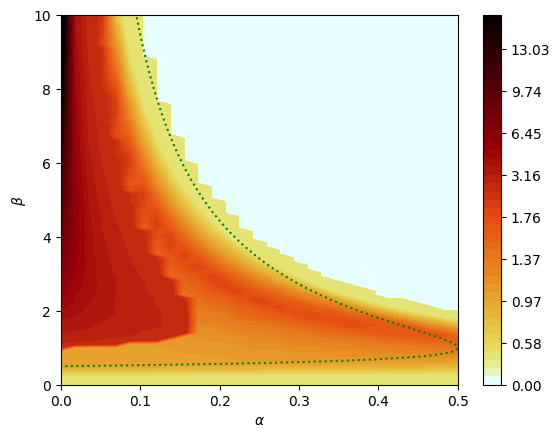

In [19]:
# Loading
AA = load(string(folder,"RKSO2CFLallEps.jld"), "AA")
BB = load(string(folder,"RKSO2CFLallEps.jld"), "BB")
QQ = load(string(folder,"RKSO2CFLallEps.jld"), "QQ")

# Color levels
levels=[0 
    0.0000001
    0.0005
    0.001
    range(0.5,stop=2, length=20)
    range(2.5,stop=15, length=20)
    21.]

k=4
nLevels=length(levels)
colls=zeros(nLevels,3)
colls[:,1]=[min(-1.6*(x-1),0.9) for x in range(0,stop=1,length=nLevels)]
colls[:,2]=[max(-1.6*x+1,0) for x in range(0,stop=1,length=nLevels)]#1-sqrt.(2*x*(1-x))
colls[:,3]=[-1/(k^2-1).+k/(k^2-1)./((k-1/k).*x.+1/k) for x in range(0,stop=1,length=nLevels)]


# contour plot of Δt bound with respect to α and β
PyPlot.contourf(AA,BB,QQ,levels, colors=colls)
PyPlot.colorbar()
xx=range(0.01,stop=10,length=400)
PyPlot.plot(1 ./xx - 1/2 ./xx.^2,xx,":g")
PyPlot.xlabel(L"\alpha")
PyPlot.ylabel(L"$\beta$")
PyPlot.xlim([minimum(AA),maximum(AA)])
#PyPlot.title("log10 Variation Lyapunov mPRK3")
PyPlot.savefig(string(folder,"RKSO2CFLallEps.pdf"))
PyPlot.show()

### MPRK43($\alpha,\beta$)
Its description is in [Kopecz et al. BIT Numer Math 58 (2018)](https://doi.org/10.1007/s10543-018-0705-1)

In [22]:
# Checking the Δt bound on some paramters

αs=[2,0.9,0.5,3.]
βs=[0.6,0.5,0.7,7.0/15.0]


# Problem paramters
extraθs=1.0 .-10.0 .^(-1:-1:-10)
θs = [10.0 .^(-10:1:-1);(0.1:0.04:0.9); extraθs]
l3= length(θs)

epsilons = [1e-300; 10.0 .^ (-7.82:0.25:-0.32); 0.49999999999]
neps=length(epsilons)

# Scheme parameters
dts=2.0 .^ (-3.0:0.025:6.0)


#Loop on schemes α, β
for (α,β) in zip(αs,βs)

    println("Testing MPRK(4,3,$(α),$(β))")
    Q3=zeros(l3)
    Threads.@threads for i3=1:l3
        θ = θs[i3]
        
        # Production and destruction functions of the problem
        param_a,param_b=  (1-θ),θ #10^2, 10^2 # 1, 1 # 
        function prod_dest(c)
            d= length(c)
            p=zeros(d,d)
            d=zeros(d,d)
            p[1,2]=param_a*c[2]
            d[2,1]=param_a*c[2]
            p[2,1]=param_b*c[1]
            d[1,2]=param_b*c[1]
            return p, d
        end

        # Steady state
        uInf=[param_a param_b]

        z=0
        overshoots=zeros(size(dts))
        
        # Loop on the timesteps
        for dt in dts
            z+=1
            tt=0:dt:dt
            overEps=zeros(size(epsilons))
            r=0
            
            # Loop on all the initial conditions
            for ep=epsilons
                r+=1
                u0=[1-ep ep]           
                tmp3=1.;
                
                # Check if we overshoot and saving the result in overEps 
                # (if troubles with the method occur, we save a 1)
                try
                    tout,uu=mPRK3(prod_dest,rhs_function, tt,u0, α,β)
                    tmp3= overshootMeasure(uu[1,1],uu[1,2],uInf[1])
                    if isnan(tmp3)
                        tmp3=1.0
                    end
                catch e
                    tmp3=1.0
                end
                overEps[r]=tmp3
            end
            
            # Finding the maximum overshoot over different IC for a given Δt and θ 
            overshoots[z]=maximum(overEps)
        end
        
        # Finding the largest Δt0 for which there are no overshoots for Δt < Δt0
        if isempty(dts[overshoots.==0])
            Q3[i3] = 0.
        else
            Q3[i3] = maximum(dts[overshoots.==0]);
        end     
    end
    println("The timestep bound is $(minimum(Q3))")
end


Testing MPRK(4,3,2.0,0.6)
The timestep bound is 1.8986842419010386
Testing MPRK(4,3,0.9,0.5)
The timestep bound is 1.5965967727133
Testing MPRK(4,3,0.5,0.7)
The timestep bound is 1.7411011265922482
Testing MPRK(4,3,3.0,0.4666666666666667)
The timestep bound is 5.370290011121053


In [20]:
# Plot on the whole parameter domain


dts=2.0 .^ (-3.0:0.05:6.0)

extraθs=1.0 .-10.0 .^(-1:-1:-10)
θs = [10.0 .^(-10:1:-1);(0.1:0.04:0.9); extraθs]


epsilons = [1e-300; 10.0 .^ (-7.82:0.25:-0.32); 0.49999999999]
neps=length(epsilons)



l1=100
l2=45
l3= length(θs)

as=range(1/3.,stop=3,length=l1)
bs=range(0.28,stop=0.75,length=l2)
AA=zeros(l1,l2)
BB=zeros(l1,l2)
QQ=zeros(l1,l2)
for k=1:l1
    print(k)
    for j= 1:l2
        AA[k,j]=as[k]
        BB[k,j]=bs[j]
        
        Q3=zeros(l3)
        Threads.@threads for i3=1:l3
            θ = θs[i3]
            param_a,param_b=  (1-θ),θ #10^2, 10^2 # 1, 1 # 
            function prod_dest(c)
                d= length(c)
                p=zeros(d,d)
                d=zeros(d,d)
                p[1,2]=param_a*c[2]
                d[2,1]=param_a*c[2]
                p[2,1]=param_b*c[1]
                d[1,2]=param_b*c[1]
                return p, d
            end

            uInf=[param_a param_b]

            z=0
            overshoots=zeros(size(dts))
            for dt in dts
                z+=1
                tt=0:dt:dt
                overEps=zeros(size(epsilons))
                r=0
                for ep=epsilons
                    r+=1
                    u0=[1-ep ep]           
                    tmp3=1.;
                    try
                        tout,uu=mPRK3(prod_dest,rhs_function, tt,u0, as[k],bs[j])
                        tmp3= overshootMeasure(uu[1,1],uu[1,2],uInf[1])
                        if isnan(tmp3)
                            tmp3=1.0
                        end
                    catch e
                        tmp3=1.0
                    end
                    overEps[r]=tmp3
                end
                overshoots[z]=maximum(overEps)
            end
            if isempty(dts[overshoots.==0])
                Q3[i3] = 0.
            else
                Q3[i3] = maximum(dts[overshoots.==0]);
            end     
        end
        QQ[k,j] = minimum(Q3);
    end
end

bestQRKSO2 = maximum(QQ)
idxs = argmax(QQ)
bestParamRKSO2=[as[idxs[1]],bs[idxs[2]]]

save(string(folder,"RK43CFLallEps.jld"), "AA", AA,"BB",BB,"QQ", QQ)

123456789101112131415161718192021222324252627282930313233343536373839404142434445464748495051525354555657585960616263646566676869707172737475767778798081828384858687888990919293949596979899100

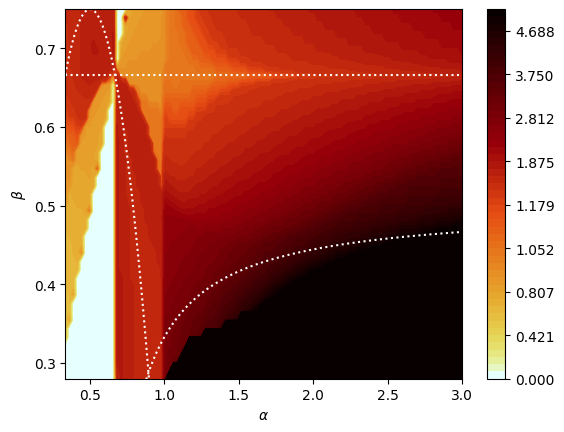

64.0


In [21]:
# loading
AA = load(string(folder,"RK43CFLallEps.jld"), "AA")
BB = load(string(folder,"RK43CFLallEps.jld"), "BB")
QQ = load(string(folder,"RK43CFLallEps.jld"), "QQ")


# color levels
levels=[0 
    range(0.1,stop=1.0, length=15)
    range(1.01,stop=1.2, length=10)
    range(1.25,stop=5, length=25)
    65]

nLevels=length(levels)
k=4
colls=zeros(nLevels,3)
colls[:,1]=[min(-1.6*(x-1),0.9) for x in range(0,stop=1,length=nLevels)]
colls[:,2]=[max(-1.6*x+1,0) for x in range(0,stop=1,length=nLevels)]#1-sqrt.(2*x*(1-x))
colls[:,3]=[-1/(k^2-1).+k/(k^2-1)./((k-1/k).*x.+1/k) for x in range(0,stop=1,length=nLevels)]


# contour plot
PyPlot.contourf(AA,BB,QQ,levels, colors=colls)
PyPlot.colorbar()
xx=range(2/3,stop=3,length=400)
PyPlot.plot(xx,(3 .*xx .-2)./(6 .*xx .-3),":w")
xx=range(1/3,stop=1,length=400)
PyPlot.plot(xx,(3 .*xx).*(1 .-xx),":w")
xx=range(1/3,stop=3,length=400)
PyPlot.plot(xx,2/3 .*ones(size(xx)),":w")
PyPlot.xlabel(L"\alpha")
PyPlot.ylabel(L"$\beta$")
PyPlot.ylim([minimum(BB),maximum(BB)])
#PyPlot.title("log10 Variation Lyapunov mPRK3")
PyPlot.savefig(string(folder,"RK43CFLallEps.pdf"))
PyPlot.show()
println(maximum(QQ))

## MPRK(4,3,$\gamma$)
Its description is in [Kopecz et al. BIT Numer Math 58 (2018)](https://doi.org/10.1007/s10543-018-0705-1)

In [23]:
# Problem parameters
extraθs=1.0 .-10.0 .^(-1:-0.3:-10)
θs = [10.0 .^(-10:0.3:-1);(0.1:0.02:0.9); extraθs]
epsilons = [1e-100; 10.0 .^ (-7.8:0.3:-1); 0.1:0.02:0.49999999999] #10.0 .^ (-8:0.1:-0.3)

# Scheme parameters
dts=(1.4:0.005:1.8)
γs = range(3.0/8.0,stop=3.0/4.0,length=21)


0.375:0.01875:0.75

In [24]:
# Checking for the whole range of schemes

l1=length(γs)
l2= length(θs)

AA=zeros(l1,l2)
BB=zeros(l1,l2)
QQ=zeros(l1,l2)
Threads.@threads for i1=1:l1
    γ=γs[i1]
    print(i1)
    tmp=1.0
    for i2=1:l2
        θ=θs[i2]
        AA[i1,i2]=γ
        BB[i1,i2]=θ
        
        param_a,param_b=  (1-θ),θ #10^2, 10^2 # 1, 1 # 
        function prod_dest(c)
            d= length(c)
            p=zeros(d,d)
            d=zeros(d,d)
            p[1,2]=param_a*c[2]
            d[2,1]=param_a*c[2]
            p[2,1]=param_b*c[1]
            d[1,2]=param_b*c[1]
            return p, d
        end

        uInf=[param_a param_b]

        function exact_solution(c0,time)
            c_exact=zeros(size(c0)[1],size(time)[1])
            a=param_a
            b=param_b
            A= [ -b a; b -a]
            for it=1:length(time)
                t=time[it]
                c_exact[:,it] = c0+(1- exp(-(a+b)*t))/(a+b).*(A*c0)
            end
            return c_exact
        end
        
        
        z=0
        overshoots=zeros(size(dts))
        us=zeros(size(dts))
        for dt in dts
            z+=1
            tt=0:dt:dt
            overEps=zeros(size(epsilons))
            r=0
            for ep=epsilons
                r+=1
                u0=[1-ep ep]
                try
                    tout,uu=mPRK3gam(prod_dest, rhs_function, tt,u0, γ)
                    tmp= overshootMeasure(uu[1,1],uu[1,2],uInf[1])
                    if isnan(tmp)
                        tmp=1.0
                    end
                catch e
                    tmp=1.0
                end
                overEps[r]=tmp
            end
            overshoots[z]=maximum(overEps)
        end
        if isempty(dts[overshoots.==0])
            QQ[i1,i2] = 0.
        else
            QQ[i1,i2] = maximum(dts[overshoots.==0]);
        end

        
    end
end
save(string(folder,"RK3gamCFLallEps.jld"), "AA", AA,"BB",BB,"QQ", QQ)

187101420131619521121817146391215

sys:1: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


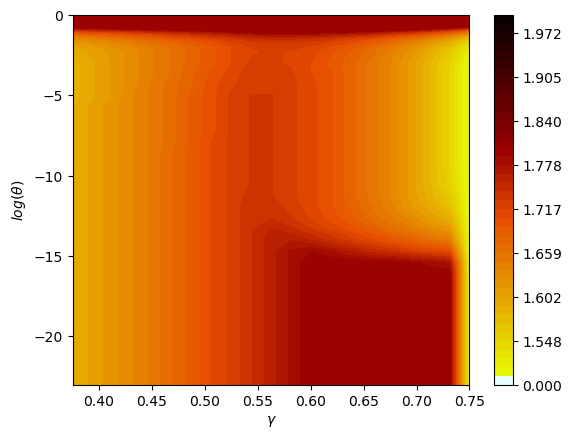

In [49]:
# Load and plot 

AA = load(string(folder,"RK3gamCFLallEps.jld"), "AA")
BB = load(string(folder,"RK3gamCFLallEps.jld"), "BB")
QQ = load(string(folder,"RK3gamCFLallEps.jld"), "QQ")

levels=[0 
    2^-6
    2. .^range(0.6,stop=1.0,step=0.01)] #    range(0.1,stop=2.5,length=60)


nLevels=length(levels)
k=nLevels
colls=zeros(nLevels,3)
colls[:,1]=[min(-1.6*(x-1),0.9) for x in range(0,stop=1,length=nLevels)]
colls[:,2]=[max(-1.6*x+1,0) for x in range(0,stop=1,length=nLevels)]#1-sqrt.(2*x*(1-x))
colls[:,3]=[-1/(k^2-1).+k/(k^2-1)./((k-1/k).*x.+1/k) for x in range(0,stop=1,length=nLevels)]

PyPlot.contourf(AA,log.(BB),QQ,levels, colors=colls)
PyPlot.colorbar()
PyPlot.xlabel(L"\gamma")
PyPlot.ylabel(L"$log(\theta)$")
#PyPlot.title("log10 Variation Lyapunov mPRK3")
PyPlot.savefig(string(folder,"RK3gamCFLallEps.pdf"))
PyPlot.show()


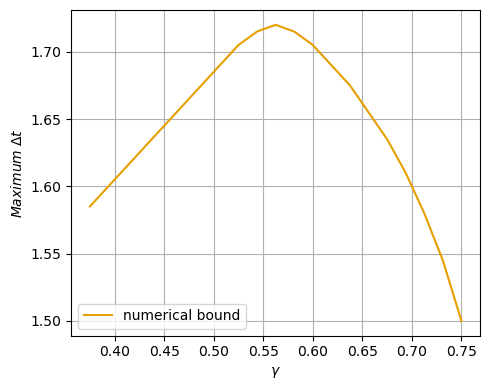

In [50]:
# load and plot
QQ = load(string(folder,"RK3gamCFLallEps.jld"), "QQ")
minα=[minimum(QQ[i,:]) for i in range(1,length=size(QQ,1))]
plt.figure(figsize=(5,4))
plt.plot(γs,minα, label="numerical bound")
#plt.plot(γs,2.35*ones(length(γs)), label="analytical upper bound")
plt.xlabel(L"\gamma")
plt.ylabel(L"Maximum\; \Delta t")
plt.grid(true)
plt.legend()
plt.tight_layout()

plt.savefig(string(folder,"RK3gamCFLallEpsAllSystems.pdf"))